In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# New Section

In [29]:
#from scipy.io import arff
!pip install liac-arff
import pandas as pd
import arff
from io import StringIO

# file read
f = open('/content/drive/My Drive/data.arff','r')
s = str(f.read())
# print(s)
check = False
csv = []
int_cols = [] # int columns
string_cols = [] # string columns
category_cols = [] # category columns
real_cols = [] # real columns
columns = [] # columns
# group. columns based on data type
for i in s.splitlines():
    if '@attribute' in i:
        attr_types = i.split(' ')
        if attr_types[2].strip() == 'INTEGER':
            int_cols.append(i.split(' ')[1])
        elif attr_types[2].strip() == 'STRING':
            string_cols.append(i.split(' ')[1])
        elif attr_types[2].strip() == 'REAL':
            real_cols.append(i.split(' ')[1])
        else:
            category_cols.append(i.split(' ')[1])
        # append columns for creating csv columns
        columns.append(i.split(' ')[1])
    if '@data' in i:
        check = True
    if check:
        csv.append(i.split(','))
# since target column is the only real value 
target_column = real_cols[0]

# creating DataFrame after reading data
df = pd.DataFrame(csv[1:], columns = columns)

# printing String columns to identify what type of variable
print(df.Running_over.unique())
print(df.Point_of_flooding.unique())



[' 0.0' ' NO' ' 1.0' ' 2.0' ' -1.0']
[' 0.0' ' 2000.0' ' 1.0' ' 3.0' ' 7.0' ' -0.0']


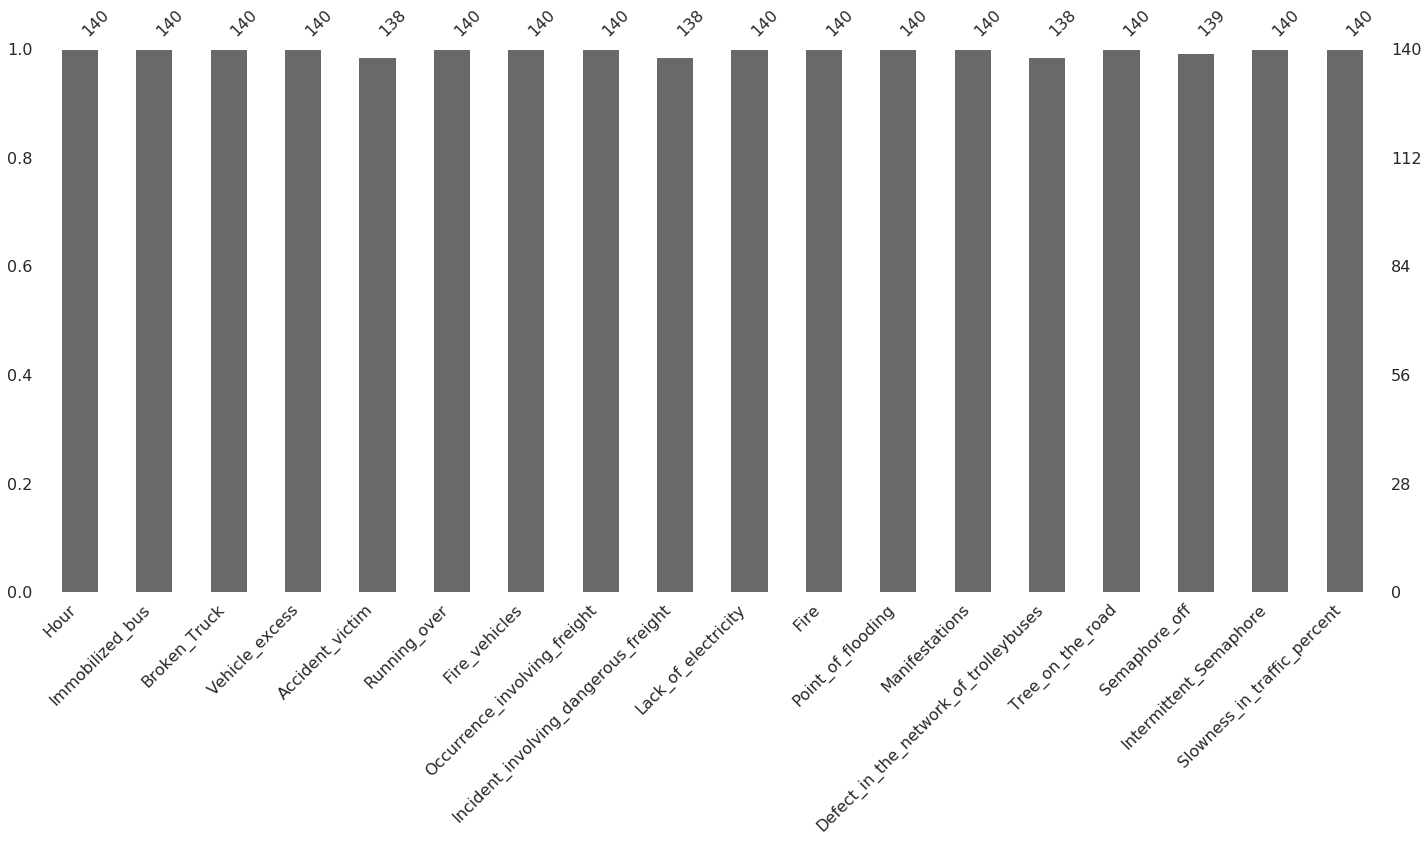

In [30]:
import numpy as np
# data cleaning by replacing space with Nan
df = df.replace('', np.nan)
df = df.replace(' ', np.nan)
import missingno as msno
# Plotting bar graph to identify missing values
msno.bar(df)

In [10]:
# converting column type to numeric
df[int_cols + real_cols] = df[int_cols + real_cols].apply(pd.to_numeric)
df.dtypes
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# mean imputation 
imp = SimpleImputer(strategy="mean")
df[int_cols + real_cols] = imp.fit_transform(df[int_cols + real_cols])
# standardizing data
scaler = StandardScaler()
df[int_cols] = scaler.fit_transform(df[int_cols].values)
# plotting correlation heat map
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(3)

,Immobilized_bus,Broken_Truck,Accident_victim,Occurrence_involving_freight,Incident_involving_dangerous_freight,Lack_of_electricity,Fire,Manifestations,Defect_in_the_network_of_trolleybuses,Tree_on_the_road,Semaphore_off,Intermittent_Semaphore,Slowness_in_traffic_percent
Immobilized_bus,1,-0.0419,-0.00177,0.0866,0.218,0.0584,-0.0438,-0.0835,0.0977,-0.000775,0.00103,0.0304,0.101
Broken_Truck,-0.0419,1,-0.0493,-0.00606,-0.00617,-0.0182,-0.00706,-0.0135,-0.00872,-0.018,-0.0212,-0.0107,-0.102
Accident_victim,-0.00177,-0.0493,1,-0.0531,0.0652,0.0969,-0.0531,-0.126,-0.00218,-0.0833,0.142,-0.0753,0.111
Occurrence_involving_freight,0.0866,-0.00606,-0.0531,1,-0.0073,-0.0196,-0.00719,0.371,-0.0106,-0.0179,0.16,-0.0102,0.0279
Incident_involving_dangerous_freight,0.218,-0.00617,0.0652,-0.0073,1,-0.0199,-0.0073,-0.398,-0.00998,-0.0182,-0.0242,-0.0104,0.00223
Lack_of_electricity,0.0584,-0.0182,0.0969,-0.0196,-0.0199,1,-0.0196,-0.0374,0.0067,-0.0489,0.594,-0.0278,0.436
Fire,-0.0438,-0.00706,-0.0531,-0.00719,-0.0073,-0.0196,1,-0.0137,-0.0106,-0.0179,-0.0239,-0.0102,-0.0449
Manifestations,-0.0835,-0.0135,-0.126,0.371,-0.398,-0.0374,-0.0137,1,0.0992,0.126,0.0951,-0.0195,0.0668
Defect_in_the_network_of_trolleybuses,0.0977,-0.00872,-0.00218,-0.0106,-0.00998,0.0067,-0.0106,0.0992,1,0.0214,-0.13,-0.015,0.0765
Tree_on_the_road,-0.000775,-0.018,-0.0833,-0.0179,-0.0182,-0.0489,-0.0179,0.126,0.0214,1,-0.0595,-0.0255,-0.094


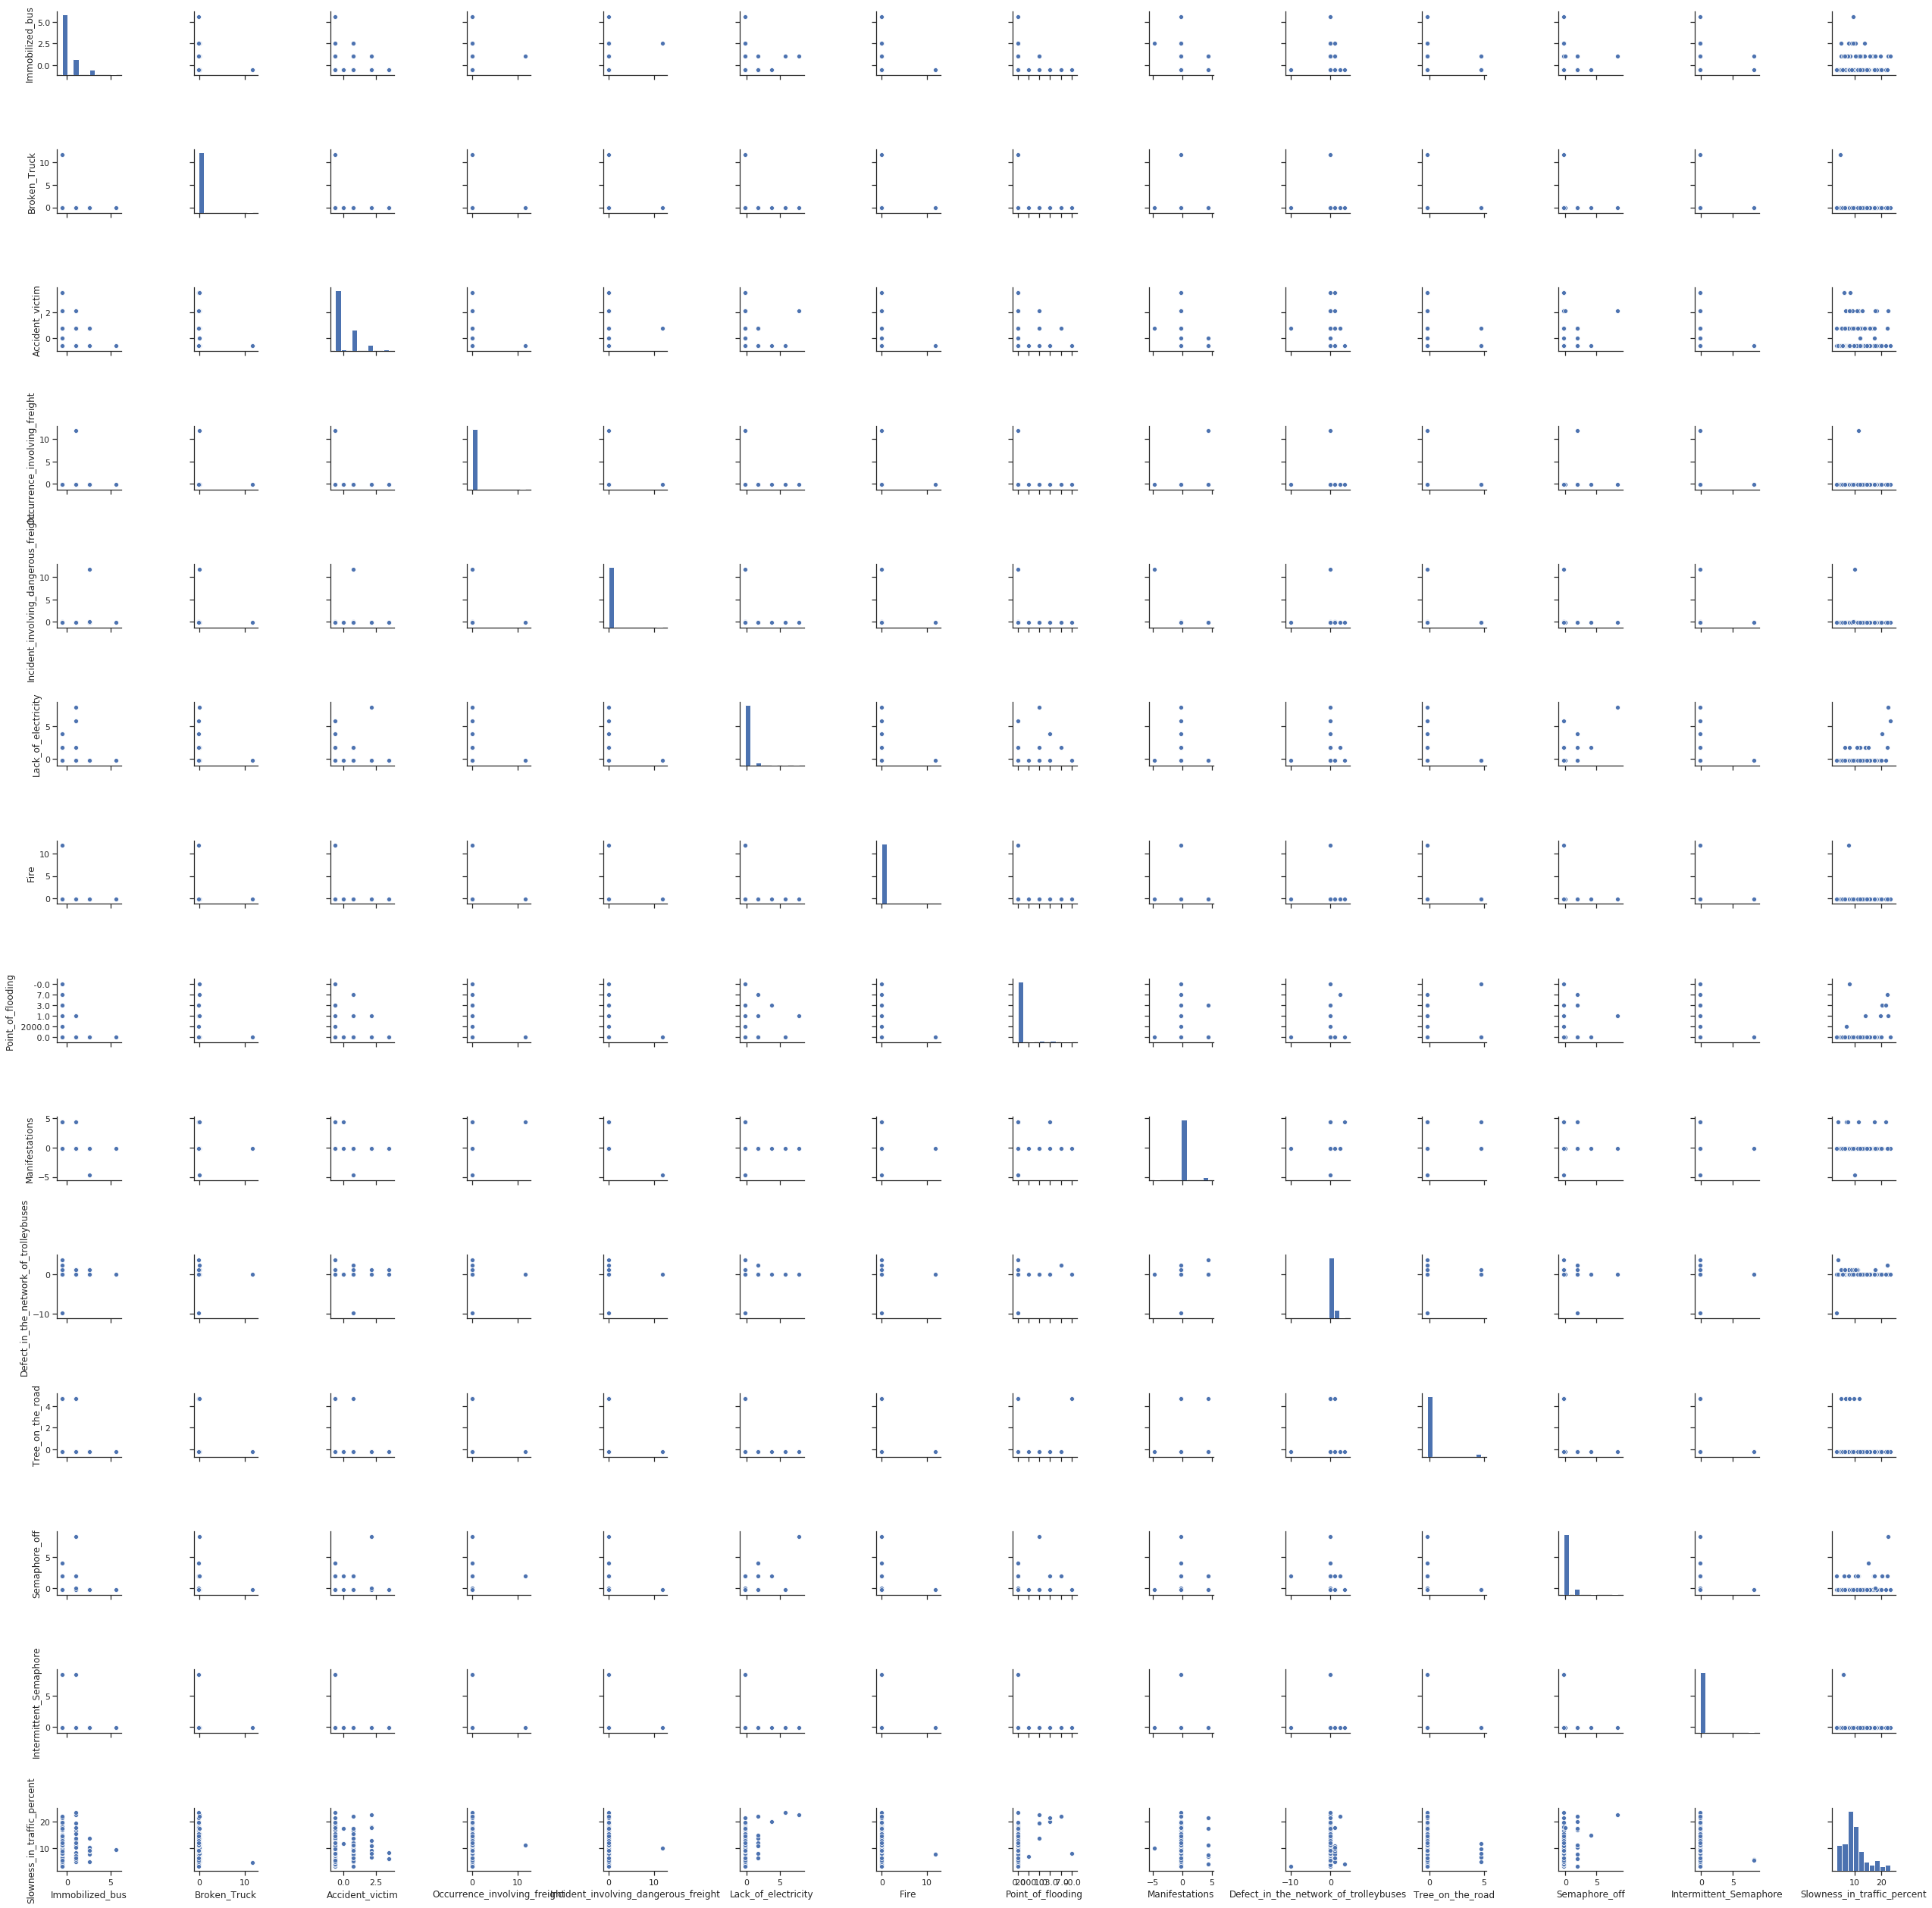

In [11]:
!pip install seaborn
import seaborn as sns; 
# plotting pair plots to identify correlation among variables
sns.set(style="ticks", color_codes=True)
sns.pairplot(df)

In [28]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.feature_extraction import DictVectorizer
# target variable values
target = df[['Slowness_in_traffic_percent']].values
input = df[int_cols].values

# encoding category variables
dv_X = DictVectorizer(sparse=False) 
df_dict = df[category_cols + string_cols].to_dict(orient='records')
encoded_categories = dv_X.fit_transform(df_dict)
# print(encoded_categories.shape)
input = np.hstack((input,encoded_categories))

# recursive feature elimination
estimator = SVR(kernel="linear")
selector = RFE(estimator,  step=1)
selector = selector.fit(input, target)
selector.support_
print(selector.ranking_)
print(input.shape)
input = selector.transform(input)
input.shape


(140, 44)
[2 1 1 4 7 1 6 3 1 5 1 1]
(140, 12)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(140, 6)

LR: 0.223744 (0.347878)
SVM: 0.126251 (0.201012)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

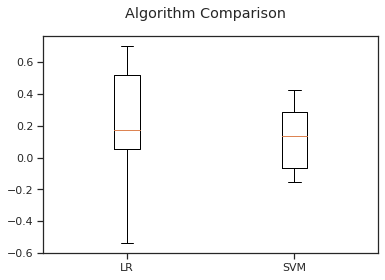

In [14]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,KFold
# test train split
X_train, X_test, y_train, y_test = train_test_split(input, target, test_size=0.2, random_state=42)
# finding best model using cross validation
models = []
models.append(('LR', LinearRegression()))
models.append(('SVM', SVR(kernel='linear')))
results = []
names = []
scoring = 'r2'
for name, model in models:
	kfold = KFold(n_splits=10, random_state=42)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()




Coefficients: 
 [[ 0.85591108  0.72186451  2.15153026 -2.20745025 -2.40089489 -0.87341103
  -0.07341103 -1.02341103 -1.55713272  0.10682844  2.76286728  4.08456936
   5.46023789  5.94325563  5.72505871  7.97791163  5.2099223  -5.34166199
  -3.49841103 -2.28341103 -2.14841103 -5.40516644 -4.17683002 -6.20024106
  -3.87647825  0.48930665 -1.22341103  0.50492538]]
Mean squared error: 11.86
Coefficient of determination: 0.56


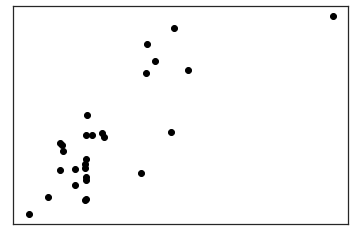

In [25]:
from sklearn.metrics import mean_squared_error, r2_score
# Taking linear regression model from model list
models[0][1].fit(X_train,y_train)
preds = models[0][1].predict(X_test)
# The coefficients
print('Coefficients: \n', models[0][1].coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, preds))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, preds))
# Plot outputs
plt.scatter(preds, y_test,  color='black')
plt.show()